# 기본 Chatbot 만들기

In [2]:
from dotenv import load_dotenv

# API-KEY 읽어오기
load_dotenv()

True

In [3]:
from langchain.chat_models import init_chat_model

# 모델 초기화
llm = init_chat_model("openai:gpt-5-nano")
# llm = init_chat_model("google_genai:gemini-2.5-flash")

### 상태는 워크플로우에서 노드 간 데이터를 전달하는 데 사용

```
messages: Annotated[list, add_messages]
```
실제 타입은 list이고, add_messages는 메시지 병합(리듀스) 전략이라는 메타데이터입니다. LangGraph가 이 메타데이터를 읽어 messages를 누적/병합합니다.

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# 에이전트의 상태 정의 클래스
class State(TypedDict):
    # Annotated: 타입 힌트
    # add_messages: 상태 업데이트 시 메시지를 덮어쓰지 않고 추가
    messages: Annotated[list, add_messages]

# 상태 기반 워크플로우 생성
graph_builder = StateGraph(State)

### 노드 추가

In [5]:
# 챗봇 노드 함수
def chatbot(state: State):
    # LLM의 출력(응답)을 messages 리스트에 추가하여 반환
    result = llm.invoke(state["messages"])
    return {"messages": [result]}


# 워크플로우에 chatbot 노드 추가
graph_builder.add_node("chatbot", chatbot)

### entry point 추가 및 compile

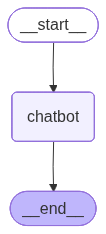

In [6]:
# 워크플로우의 시작점(START)에서 'chatbot' 노드로 이동하는 엣지 추가
graph_builder.add_edge(START, "chatbot")
# 'chatbot' 노드에서 워크플로우의 종료점(END)로 이동하는 엣지 추가
graph_builder.add_edge("chatbot", END)
# 워크플로우 컴파일, 실행 가능한 워크플로우 생성
graph = graph_builder.compile()
graph

### chatbot 실행
  
| 구분                                   | 실행 시점            | 반환 시점                       | 반환 내용                     | 사용 목적                         |
| ------------------------------------ | ---------------- | --------------------------- | ------------------------- | ----------------------------- |
| `invoke()`                           | 전체 그래프 한 번 실행    | **모든 노드가 끝난 뒤 한 번만 반환**     | 최종 state (모든 messages 포함) | 결과만 필요할 때                     |
| `stream(..., stream_mode="updates")` | 그래프 각 노드 실행마다 반환 | **각 노드 종료 시마다 변경된 부분만 반환**  | 추가된 messages, 변경분(delta)  | 실시간 업데이트/로그용 (가장 효율적)         |
| `stream(..., stream_mode="values")`  | 그래프 각 노드 실행마다 반환 | **각 노드 종료 시마다 전체 state 반환** | 누적된 전체 messages           | 단계별 전체 흐름 보기 (values 기반 스트리밍) |

In [7]:
user_input = "LangGraph와 LangChain의 차이점에 대해 짧게 설명해줘"
# 그래프를 invoke 모드로 실행
result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
result

{'messages': [HumanMessage(content='LangGraph와 LangChain의 차이점에 대해 짧게 설명해줘', additional_kwargs={}, response_metadata={}, id='c5875f04-f737-4f33-8eca-d628204ed29e'),
  AIMessage(content='짧은 차이점 요약:\n\n- LangChain\n  - 정의: LLM 앱 구축에 쓰이는 널리 쓰이는 프레임워크. 체인(chains), 에이전트(agents), 도구(tools), 메모리(memory) 등을 중심으로 설계.\n  - 흐름: 주로 순차적이거나 에이전트 중심의 흐름을 표준화된 컴포넌트로 구성.\n  - 생태계: 문서와 플러그인/통합이 풍부하고, Python과 JavaScript 등 多언어 지원이 잘 되어 있음.\n  - 용도: 빠른 프로토타이핑, 다양한 도구/서비스 연결, 일반적인 LLM 응용에 적합.\n\n- LangGraph\n  - 정의: 그래프 기반의 LLM 워크플로우 오케스트레이션 프레임워크. 노드-엣지 그래프를 통해 태스크와 데이터 흐름을 명시적으로 표현.\n  - 흐름: 노드 간 의존성, 조건부 흐름, 병렬성 등 데이터 흐름을 그래프로 직접 모델링.\n  - 특징: 재현성과 디버깅에 유리하고, 복잡한 비선형 워크플로우를 관리하기에 적합.\n  - 용도: 그래프 중심의 모듈식 워크플로우를 설계하고 재사용하려는 경우에 강점.\n\n간단히 말해, LangChain은 체인/에이전트 중심의 넓은 생태계와 빠른 개발에 적합한 반면, LangGraph는 그래프 기반으로 복잡한 의존성과 데이터 흐름을 명시적으로 다루는 워크플로우에 초점을 둡니다. 필요에 따라 두 도구를 함께 쓰기도 좋습니다. 더 자세한 비교나 예제가 필요하면 말해줘.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1756, 'prompt_

In [8]:
user_input = "LangGraph와 LangChain의 차이점에 대해 짧게 설명해줘"
# 그래프를 스트리밍 모드로 실행
events = graph.stream({"messages": [{"role": "user", "content": user_input}]}, stream_mode="updates")
for event in events:  
    print(event)

{'chatbot': {'messages': [AIMessage(content='짧게 요약하면:\n\n- LangChain: LLM 애플리케이션을 체인(또는 에이전트) 방식으로 구성하는 프레임워크. 프롬프트 템플릿, 체인/에이전트 관리, 도구 연결, 메모리 등 광범위한 기능을 제공하고 생태계가 매우 큽니다.\n- LangGraph: 이름이 같은 다른 프로젝트일 가능성이 있어 정확한 차이를 말하려면 어느 것을 가리키는지 확인이 필요합니다. 일반적으로 “그래프(노드/엣지) 기반의 추론이나 의사결정”에 초점을 둔 도구일 수 있습니다. 즉, 그래프 표현으로 지식 연결이나 다단계 추론을 다루는 방향일 가능성이 있습니다.\n\n정확한 비교를 위해:\n- 어떤 LangGraph 레포트 가리키는지 링크를 보내주시면, 그 구현과 LangChain의 특정 버전과의 차이를 구체적으로 짚어 드리겠습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1701, 'prompt_tokens': 23, 'total_tokens': 1724, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 1472, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CNSepqmVn4sbRyKh4SeslF2XnwrDK', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a615bbac

In [20]:
user_input = "LangGraph와 LangChain의 차이점에 대해 짧게 설명해줘"
# 그래프를 스트리밍 모드로 실행
events = graph.stream({"messages": [{"role": "user", "content": user_input}]}, stream_mode="values")
for event in events:  
    print(event)

{'messages': [HumanMessage(content='LangGraph와 LangChain의 차이점에 대해 짧게 설명해줘', additional_kwargs={}, response_metadata={}, id='fa31a26c-99f6-4ec5-b967-c46aa956ed55')]}
{'messages': [HumanMessage(content='LangGraph와 LangChain의 차이점에 대해 짧게 설명해줘', additional_kwargs={}, response_metadata={}, id='fa31a26c-99f6-4ec5-b967-c46aa956ed55'), AIMessage(content='짧게 비교하면 다음과 같습니다.\n\n- 목적\n  - LangChain: LLM 애플리케이션을 쉽게 구축하도록 프롬프트, 도구, 메모리, 에이전트 등을 조합하는 라이브러리.\n  - LangGraph: LLM 워크플로를 그래프(노드-에지)로 표현하고 실행하는 프레임워크로, 작업 간 의존성 관리에 초점.\n\n- 구성 요소\n  - LangChain: Chains, Agents, Tools, Memory 등 고수준 구성요소 중심.\n  - LangGraph: 노드/에지 그래프와 DAG 실행 엔진 중심.\n\n- 실행 방식\n  - LangChain: 순차 체인이나 에이전트의 도구 호출 흐름 위주.\n  - LangGraph: 그래프 의존성에 따라 병렬 실행이나 서브그래프 재사용을 가능하게 하는 DAG 기반 실행.\n\n- 생태계/적용 범위\n  - LangChain: 넓은 생태계와 다수의 LLM/툴 통합으로 다목적 애플리케이션에 적합.\n  - LangGraph: 그래프 기반 워크플로 관리나 데이터 흐름 파이프라인 같은 복잡한 흐름에 강점이 있을 수 있음.\n\n원하시면 두 라이브러리의 공식 문서를 확인해 더 구체적으로 비교해 드릴게요. 어떤 사용 사례를 생각하고 계신가요?', additional_kwargs={'refusal': None}, res

In [21]:
def stream_graph_updates(user_input: str):
    # 그래프를 스트리밍 모드로 실행
    events = graph.stream({"messages": [{"role": "user", "content": user_input}]})
    for event in events:
        for value in event.values():
            # 최신 메시지(마지막 메시지)의 내용을 출력
            value["messages"][-1].pretty_print()


while True:
    try:
        user_input = input("User: ")  # 사용자 입력 받기
        if user_input.lower() in ["quit", "exit", "q"]:  # 종료 조건
            print("Goodbye!")
            break
        stream_graph_updates(user_input)  # 워크플로우 실행
    except:
        break

User:  안녕!


================================== Ai Message ==================================

안녕하세요! 반가워요. 무엇을 도와드릴까요?

간단한 대화 연습, 번역, 글쓰기 도움, 정보 검색, 문제 해결 등 어떤 주제든 말씀해 주세요. 원하시는 방식으로 바로 도와드릴게요.


User:  LangChain이 뭐야


================================== Ai Message ==================================

LangChain은 LLM(대형 언어 모델) 기반 애플리케이션을 쉽게 만들 수 있게 도와주는 오픈소스 프레임워크예요. 프롬프트 작성, LLM 호출, 외부 도구 사용, 기억(memory) 관리 등을 체계적으로 구성하는 다양한 구성 요소를 제공합니다.

주요 포인트
- 프레임워크의 핵심 아이디어: 여러 단계의 “체인(chains)”으로 LLM 호출을 연결하고, 필요하면 외부 도구(API, 검색, 데이터베이스 등)을 호출하게 만듦.
- 구성 요소
  - LLMs: OpenAI, Cohere, Hugging Face 등의 모델과 쉽게 연결
  - Prompts와 PromptTemplate: 질문/지시문을 재사용 가능한 템플릿으로 구성
  - Chains: 간단한 순차 체인부터 복잡한 워크플로까지 연결
  - Agents와 Tools: 에이전트가 상황에 맞춰 도구를 선택하고 사용
  - Memory: 대화 맥락 기억, 대화 상태 유지
  - Vector Stores와 Embeddings: 문서 검색(RAG)용 인덱스(예: FAISS, Chroma)
  - Document Loaders: PDF, HTML 등 문서를 로드하고 처리
- 사용 사례
  - 챗봇/대화형 에이전트
  - 검색-기반 질의응답(RAG) 시스템
  - 문서 요약, 정보 추출
  - 외부 API와의 자동화 워크플로우(날씨 조회, 데이터베이스 질의 등)
- 설치와 시작
  - 설치: pip install langchain
  - 기본 흐름 예시: LLM을 불러오고 PromptTemplate로 질문을 만들고 LLMChain으로 실행
- 주의점
  - 비용 관리: API 사용량에 따른 비용 발생
  - 데이터 프라이버시와 보안
  - 모델의 한계와 응답 품질 관리

간단한 예시 느낌
- 간단한 Q&A 체인 구성:
  - LLM 인스턴스
  - PromptTempl

User:  quit


Goodbye!


### MemorySaver checkpointer 생성

In [9]:
from langgraph.checkpoint.memory import MemorySaver

# MemorySaver: 워크플로우의 상태를 메모리에 저장
memory = MemorySaver()

In [13]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# 에이전트의 상태 정의 클래스
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 상태 기반 워크플로우 생성
graph_builder = StateGraph(State)

# 웹 검색을 도구 리스트에 추가
tool = TavilySearch(max_results=2)
tools = [tool]

# LLM에 도구를 바인딩하여 도구 호출 가능하게 설정
llm_with_tools = llm.bind_tools(tools)

# chatbot 노드 함수
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 워크플로우에 chatbot 노드 추가
graph_builder.add_node("chatbot", chatbot)

# LangGraph의 prebuilt ToolNode를 사용
tool_node = ToolNode(tools=[tool])
# tool 노드 워크플로우에 추가
graph_builder.add_node("tools", tool_node)

# 조건부 라우팅: tools로 이동하거나 END로 이동 (종료)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,  # 마지막 메시지에 `tool_calls`가 있는지 확인                
)

# tools 노드 실행 후 chatbot 노드로 다시 이동 (도구 결과 처리)
graph_builder.add_edge("tools", "chatbot")
# 워크플로우 시작점에서 chatbot 노드로 이동
graph_builder.add_edge(START, "chatbot")

# memory checkpointer 사용 compile
graph = graph_builder.compile(checkpointer=memory)
graph;

In [14]:
# 그래프를 ASCII 아트로 출력
print(graph.get_graph().draw_ascii())

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +---------+         
          | chatbot |         
          +---------+         
          .         *         
        ..           **       
       .               *      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


In [15]:
# 대화 세션을 구분하기 위한 설정
# thread_id는 대화의 고유 식별자로, MemorySaver가 대화 기록을 저장/로드하는 데 사용
config = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input: str):
    # 워크플로우를 스트리밍 모드로 실행 (사용자 입력 처리)
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config=config
    )
    for event in events:
        for value in event.values():
            # 이벤트의 마지막 메시지 출력
            value["messages"][-1].pretty_print()


while True:
    try:
        user_input = input("사용자: ")  # 사용자 입력 받기
        if user_input.lower() in ["quit", "exit", "q"]:  # 종료 조건
            print("Goodbye!")
            break

        # 워크플로우 실행
        stream_graph_updates(user_input)
    except:
        break

사용자:  안녕 나는 길동이야


================================== Ai Message ==================================

길동님, 반가워요! 저는 여기 있어요. 어떤 걸 도와드릴까요? 예시로 아래 중에서 원하시는 것을 말씀해 주셔도 됩니다.

- 한국어 대화 연습이나 문장 다듬기
- 글쓰기 아이디어나 글 점검
- 정보 찾고 요약해 드리기
- 코딩이나 기술 질문 해결
- 여행 plan이나 취미 이야기

혹시 지금 한국어로 간단한 자기소개를 좀 더 자연스럽게 다듬어 볼까요? 예시도 만들어 드릴 수 있어요.

오늘은 어떤 주제로 시작해 볼까요?


사용자:  내 이름이 뭐라고?


================================== Ai Message ==================================

당신의 이름은 길동입니다.

필요하면 더 자연스럽게 소개하는 문장도 만들어 드릴게요. 몇 가지 예시를 드리면:
- 공식/겸손한 톤: 안녕하세요. 제 이름은 길동입니다.
- 일상적인 톤: 안녕하세요, 저는 길동이에요.
- 친구나 네트워킹: 안녕, 나는 길동이라고 해.

원하는 톤이나 상황이 있으면 알려 주세요. 그에 맞춰 다듬어 드릴게요.


사용자:  quit


Goodbye!


In [16]:
# 새로운 thread_id 사용 (새로운 대화 세션)
config = {"configurable": {"thread_id": "2"}}

def stream_graph_updates(user_input: str):
    # 워크플로우를 스트리밍 모드로 실행 (사용자 입력 처리)
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config=config, stream_mode="values"
    )
    for event in events:
        event["messages"][-1].pretty_print()

while True:
    try:
        user_input = input("사용자: ")  # 사용자 입력 받기
        if user_input.lower() in ["quit", "exit", "q"]:  # 종료 조건
            print("Goodbye!")
            break

        # 워크플로우 실행
        stream_graph_updates(user_input)
    except:
        break

사용자:  내 이름이 뭐라고?


================================ Human Message =================================

내 이름이 뭐라고?
================================== Ai Message ==================================

지금 이 대화에서 당신의 이름을 알 수 없어요. 이름을 알려주시면 그 이름으로 불러드리겠습니다. 원하시는 호칭이 있다면 그것도 말씀해 주세요. 예를 들어 “수민님”이나 “수민”처럼 불러드리면 됩니다. 편하신 방식으로 알려주시면 되어요.


사용자:  quit


Goodbye!


### state 검사

In [20]:
# thread_id: 1
config = {"configurable": {"thread_id": "1"}}

# config에 해당하는 워크플로우의 상태 스냅샷 조회
snapshot = graph.get_state(config)

print("-" * 20, "messages", "-" * 20)
for v in snapshot.values['messages']:
    print(v)
print("-" * 20, "config", "-" * 20)
print(snapshot.config)
print("-" * 20, "next", "-" * 20)
print(snapshot.next)

-------------------- messages --------------------
content='안녕 나는 길동이야' additional_kwargs={} response_metadata={} id='4716092e-d87d-4643-a92a-8920e72722df'
content='길동님, 반가워요! 저는 여기 있어요. 어떤 걸 도와드릴까요? 예시로 아래 중에서 원하시는 것을 말씀해 주셔도 됩니다.\n\n- 한국어 대화 연습이나 문장 다듬기\n- 글쓰기 아이디어나 글 점검\n- 정보 찾고 요약해 드리기\n- 코딩이나 기술 질문 해결\n- 여행 plan이나 취미 이야기\n\n혹시 지금 한국어로 간단한 자기소개를 좀 더 자연스럽게 다듬어 볼까요? 예시도 만들어 드릴 수 있어요.\n\n오늘은 어떤 주제로 시작해 볼까요?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 784, 'prompt_tokens': 1356, 'total_tokens': 2140, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 640, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CNSgMpLy9kJ3EYmNCmT7t93cZ2DI0', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--e022a5cf-00e7-440d-8ffe-a2e95ad2522f-0' usa

In [21]:
# thread_id: 2
config = {"configurable": {"thread_id": "2"}}

# config에 해당하는 워크플로우의 상태 스냅샷 조회
snapshot = graph.get_state(config)

print("-" * 20, "messages", "-" * 20)
for v in snapshot.values['messages']:
    print(v)
print("-" * 20, "config", "-" * 20)
print(snapshot.config)
print("-" * 20, "next", "-" * 20)
print(snapshot.next)

-------------------- messages --------------------
content='내 이름이 뭐라고?' additional_kwargs={} response_metadata={} id='8e4c1b4e-eeed-4e0d-82d9-ae9995e3ff39'
content='지금 이 대화에서 당신의 이름을 알 수 없어요. 이름을 알려주시면 그 이름으로 불러드리겠습니다. 원하시는 호칭이 있다면 그것도 말씀해 주세요. 예를 들어 “수민님”이나 “수민”처럼 불러드리면 됩니다. 편하신 방식으로 알려주시면 되어요.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 596, 'prompt_tokens': 1355, 'total_tokens': 1951, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 512, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CNSh9uizr3qz6uZ4Rp02hzGUSPTmm', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--5947c562-6ade-44ab-8ffc-6ab33073e04d-0' usage_metadata={'input_tokens': 1355, 'output_tokens': 596, 'total_tokens': 1951, 'input_token_details': {'audio': 0, 